Model loaded successfully!
Training samples: 125
Validation samples: 32
Epoch 1/3
125/125 ━━━━━━━━━━━━━━━━━━━━ 700s 5s/step - accuracy: 0.6559 - loss: 1.1289 - sparse_top_k_categorical_accuracy: 0.9024 - val_accuracy: 0.9500 - val_loss: 0.6969 - val_sparse_top_k_categorical_accuracy: 0.9960
Epoch 2/3
125/125 ━━━━━━━━━━━━━━━━━━━━ 672s 5s/step - accuracy: 0.9777 - loss: 0.1035 - sparse_top_k_categorical_accuracy: 0.9998 - val_accuracy: 0.9860 - val_loss: 0.1180 - val_sparse_top_k_categorical_accuracy: 1.0000
Epoch 3/3
125/125 ━━━━━━━━━━━━━━━━━━━━ 669s 5s/step - accuracy: 0.9921 - loss: 0.0522 - sparse_top_k_categorical_accuracy: 0.9998 - val_accuracy: 0.9860 - val_loss: 0.0536 - val_sparse_top_k_categorical_accuracy: 1.0000


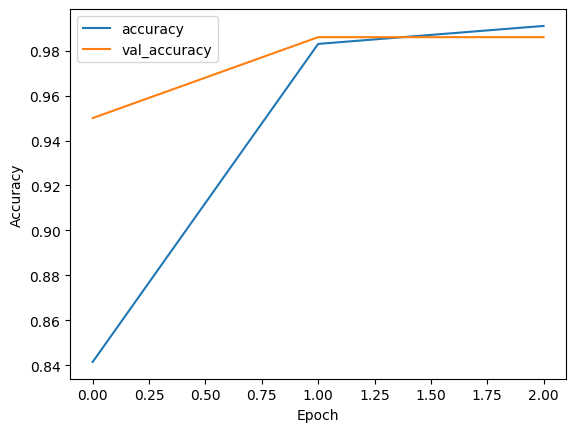

32/32 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - accuracy: 0.9809 - loss: 0.0628 - sparse_top_k_categorical_accuracy: 1.0000
Test Results: [0.05357072874903679, 0.9860000014305115, 1.0]
Test Accuracy: 0.9860000014305115


In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import os

# Load ImageNet Mini dataset (subset of ImageNet)
(ds_train, ds_test), ds_info = tfds.load(
    'imagenette/full-size', split=['train[:40%]', 'validation'], as_supervised=True, with_info=True
)

# Preprocess function
def format_image(image, label):
    image = tf.image.resize(image, (224, 224)) / 255.0
    return image, label

ds_train = ds_train.map(format_image).take(2000).batch(16).shuffle(500)
ds_test = ds_test.map(format_image).take(500).batch(16)

# Ensure cache directory exists
os.environ["TFHUB_CACHE_DIR"] = "/tmp/tfhub_modules"

# Load a powerful vision model from TensorFlow Hub (Swin Transformer)
swin_model = hub.KerasLayer(
    "https://tfhub.dev/sayakpaul/swin_tiny_patch4_window7_224_fe/1", input_shape=(224, 224, 3), trainable=True
)

print("Model loaded successfully!")

# Build Model using Functional API
inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.layers.Lambda(lambda img: swin_model(img))(inputs)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(ds_info.features['label'].num_classes, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0005),  # Lower LR for fine-tuning
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy', 'sparse_top_k_categorical_accuracy']
)

print(f'Training samples: {sum(1 for _ in ds_train)}')
print(f'Validation samples: {sum(1 for _ in ds_test)}')

# Train the model
history = model.fit(ds_train, epochs=3, validation_data=ds_test)

# Plot results
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate on test set
results = model.evaluate(ds_test)
print("Test Results:", results)
print("Test Accuracy:", results[1])
